In [5]:
# Load the trained model
# Provide a way to test a single image
# Provide a way to test an entire scan, every slice
# Provide a way to test a partial scan (below a certain slice)

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import glob
import os
from tf_unet import unet
from tf_unet.image_util import ImageDataProvider
from PIL import Image
from natsort import natsorted

#modelPath = '../_data/localizer_model/unet_trained/model.ckpt'
modelPath = './unet_trained/model.ckpt'
plt.rcParams['image.cmap'] = 'gray'
np.random.seed(98765)

class GrayImageDataProvider(ImageDataProvider):
    def __init__(self, search_path, a_min=None, a_max=None, data_suffix=".png", mask_suffix='.png', shuffle_data=False, augment_data=False):
        self.augment_data = augment_data
        super(GrayImageDataProvider, self).__init__(search_path, a_min, a_max, data_suffix, mask_suffix, shuffle_data)

    def _load_file(self, path, dtype=np.float32):
        im = Image.open(path).convert('L')
        return np.array(im, dtype)
    
    def _post_process(self, data, labels):
        if (self.augment_data):
            data_aug, labels_aug = do_augment_data(data, labels)
        else:
            data_aug, labels_aug = data, labels
        return data_aug, labels_aug;

class SingleImageDataProvider(GrayImageDataProvider):
    def __init__(self, search_path):
        super(SingleImageDataProvider, self).__init__(search_path, a_min=None, a_max=None, data_suffix='.png', mask_suffix='.png', shuffle_data=False, augment_data=False)

    def _find_data_files(self, search_path):
        all_files = glob.glob(search_path)
        return [name for name in all_files]

class FolderDataProvider(GrayImageDataProvider):
    def __init__(self, search_path):
        super(FolderDataProvider, self).__init__(os.path.join(search_path, '*.png'), a_min=None, a_max=None, data_suffix='.png', mask_suffix='.png', shuffle_data=False, augment_data=False)

    def _find_data_files(self, search_path):
        all_files = glob.glob(search_path)
        return natsorted([name for name in all_files])
    
    


2019-11-05 23:33:37,921 Layers 3, features 32, filter size 3x3, pool size: 2x2


Number of files used: 1
Number of channels: 1
Number of classes: 2
channels 1
classes 2
INFO:tensorflow:Restoring parameters from ./unet_trained/model.ckpt


2019-11-05 23:33:38,862 Restoring parameters from ./unet_trained/model.ckpt
2019-11-05 23:33:38,929 Model restored from file: ./unet_trained/model.ckpt


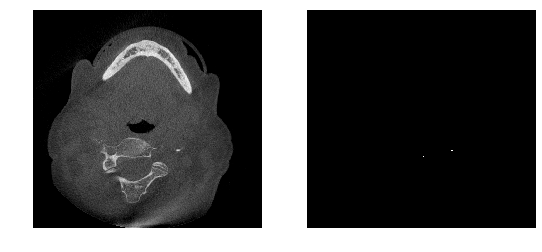

In [8]:
# Test a single image

#filePath = '../_data/png/36/36_137.png'
#filePath = '../_data/png/1/1_98.png'
#filePath = '../_data/png/32/32_116.png'
#filePath = '../_data/png/27/27_160.png'
#filePath = '../_data/png/29/29_356.png'
#filePath = '../_data/png/37/37_269.png'
filePath = '../_data/png/1/1_126.png'

# data generator
testGenerator = SingleImageDataProvider(filePath)
x_test, y_test = testGenerator(1)

# load neural network
print('channels', testGenerator.channels)
print('classes', testGenerator.n_class)
testNet = unet.Unet(channels=testGenerator.channels, n_class=testGenerator.n_class, layers=3, features_root=32)

# run prediction
prediction = testNet.predict(modelPath, x_test)
mask = prediction[0,...,1] > 0.1
#mask = prediction[0,...,1]
mask = np.pad(mask, (20,20), 'constant', constant_values=(0, 0))

# graph it
fig, ax = plt.subplots(1,2, sharex=True, sharey=True, figsize=(9,4))
ax[0].axis('off')
ax[1].axis('off')
ax[0].imshow(x_test[0,...,0], aspect='auto')
ax[1].imshow(mask, aspect='auto')

2019-11-05 23:34:21,046 Layers 3, features 32, filter size 3x3, pool size: 2x2


Number of files used: 192
Number of channels: 1
Number of classes: 2
INFO:tensorflow:Restoring parameters from ./unet_trained/model.ckpt


2019-11-05 23:34:23,072 Restoring parameters from ./unet_trained/model.ckpt
2019-11-05 23:34:23,131 Model restored from file: ./unet_trained/model.ckpt


INFO:tensorflow:Restoring parameters from ./unet_trained/model.ckpt


2019-11-05 23:34:24,622 Restoring parameters from ./unet_trained/model.ckpt
2019-11-05 23:34:24,677 Model restored from file: ./unet_trained/model.ckpt


INFO:tensorflow:Restoring parameters from ./unet_trained/model.ckpt


2019-11-05 23:34:26,163 Restoring parameters from ./unet_trained/model.ckpt
2019-11-05 23:34:26,222 Model restored from file: ./unet_trained/model.ckpt


INFO:tensorflow:Restoring parameters from ./unet_trained/model.ckpt


2019-11-05 23:34:27,691 Restoring parameters from ./unet_trained/model.ckpt
2019-11-05 23:34:27,748 Model restored from file: ./unet_trained/model.ckpt


INFO:tensorflow:Restoring parameters from ./unet_trained/model.ckpt


2019-11-05 23:34:29,207 Restoring parameters from ./unet_trained/model.ckpt
2019-11-05 23:34:29,268 Model restored from file: ./unet_trained/model.ckpt


INFO:tensorflow:Restoring parameters from ./unet_trained/model.ckpt


2019-11-05 23:34:30,726 Restoring parameters from ./unet_trained/model.ckpt
2019-11-05 23:34:30,791 Model restored from file: ./unet_trained/model.ckpt


INFO:tensorflow:Restoring parameters from ./unet_trained/model.ckpt


2019-11-05 23:34:32,228 Restoring parameters from ./unet_trained/model.ckpt
2019-11-05 23:34:32,293 Model restored from file: ./unet_trained/model.ckpt


INFO:tensorflow:Restoring parameters from ./unet_trained/model.ckpt


2019-11-05 23:34:33,884 Restoring parameters from ./unet_trained/model.ckpt
2019-11-05 23:34:33,951 Model restored from file: ./unet_trained/model.ckpt


KeyboardInterrupt: 

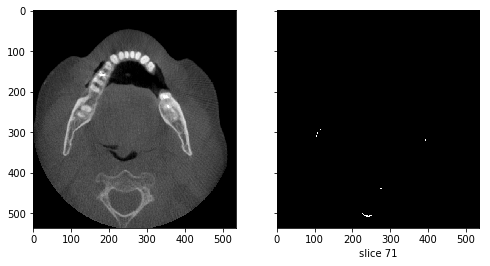

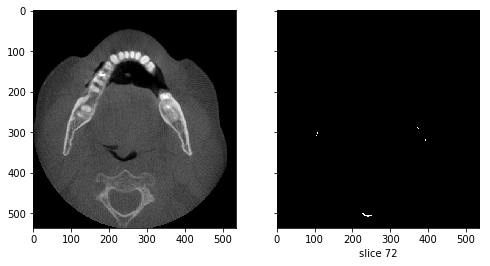

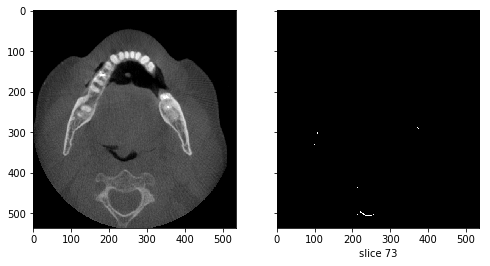

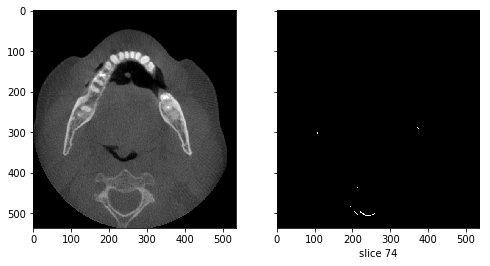

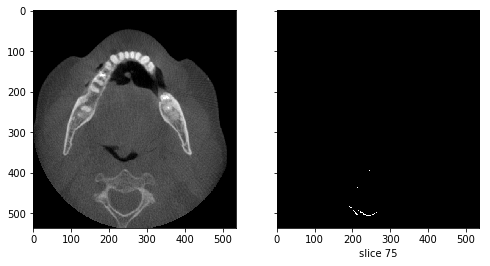

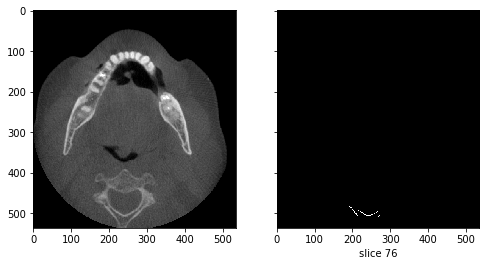

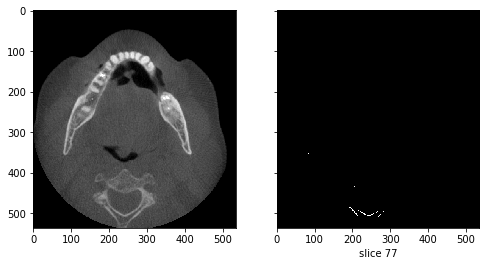

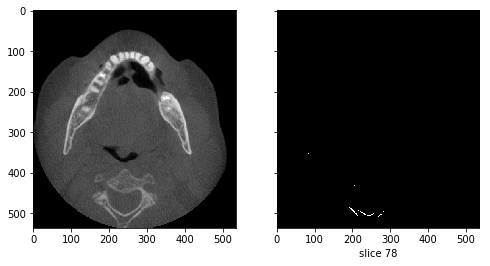

In [9]:
# Test an entire study

folderPath = '../_data/png/2'
startSlice = 71
ignoreMargin = 7

# data generator
testGenerator = FolderDataProvider(folderPath)

# load neural network
testNet = unet.Unet(channels=testGenerator.channels, n_class=testGenerator.n_class, layers=3, features_root=32)

# fast-forward generator to startSlice
testGenerator(startSlice)

for i in range(startSlice, len(testGenerator.data_files) - ignoreMargin):
    # load data
    x_test, y_test = testGenerator(1)
    
    # run prediction
    prediction = testNet.predict(modelPath, x_test)
    mask = prediction[0,...,1] > 0.05
    mask = np.pad(mask, (20,20), 'constant', constant_values=(0, 0))

    # graph it
    fig, ax = plt.subplots(1,2, sharex=True, sharey=True, figsize=(8,4))
    plt.xlabel('slice {}'.format(i))
    ax[0].imshow(x_test[0,...,0], aspect='auto')
    ax[1].imshow(mask, aspect='auto')